# Precipitation composites

Want to express the typical patterns of the months considered to be within El Niño periods.

## Masking unreliable values

Here, want to calculate statistics of the events, ignoring values that are below a suggested error threshold.

### Set environment

In [1]:
#--- Libraries
import matplotlib.pyplot as plt      # plotting package
import seaborn as sns                # plotting aestetics
import netCDF4 as nc                 # package to read NetCDF files
import pandas as pd                  # packages for statistics
import numpy as np                   # packages for linear algebra
import itertools

from mpl_toolkits.axes_grid1 import ImageGrid       # plot setting libraries
from collections import OrderedDict                 # dictionaries with fixed sequence of entries
from mpl_toolkits.basemap import Basemap            # map making libraries
from cdo import *                                   # access external NetCDF data processing routines
cdo = Cdo()                          

%matplotlib inline

/home/tristan/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#--- Arrange data
# load data files
ncfile_anom = nc.Dataset('data/precip.mon.mean.safr.anom.elnino.nc')
ncfile_mask = nc.Dataset('data/mask.abserror.safr.elnino.nc')
# get coordinates of data
lons = ncfile_anom.variables['lon'][:]
lats = ncfile_anom.variables['lat'][:]
# add extra point for grid fill
lons = np.append(lons,lons[-1]+2)
lats = np.append(lats,lats[-1]-2)
# set coordinates list as grid of locations
lons, lats = np.meshgrid(lons,lats)
# shift so that lines show grid box boundaries, 
#    rather than grid point locations
lons = lons - (2/2)
lats = lats + (2/2)
# create dictionary to store results
comps = OrderedDict()

### Mean 

The most common composite statistics is the group mean. Here calculate and plot the mean values of all the data within the El Niño period. 

In [3]:
#--- Calculate mean, masking anomalies below error threshold 
# set file to store results
anom_mean_masked = np.copy(ncfile_anom.variables['precip'][0,:,:])
# loop over all grid points
for i in itertools.product(range(anom_mean_masked.shape[0]),range(anom_mean_masked.shape[1])) :
    # pull time series of given location
    Z = ncfile_anom.variables['precip'][:,i[0],i[1]]
    # mask region
    Z[ncfile_mask.variables['precip'][:,i[0],i[1]] > 0.2] = np.nan
    # calculate mean
    anom_mean_masked[i[0],i[1]] = np.nanmean(Z)

# create dictionary reference
comps['mean (masked data)'] = anom_mean_masked

### Median

Can also calculate the median values for each grid cell.

In [4]:
#--- Calculate mean, masking anomalies below error threshold 
# set file to store results
anom_median_masked = np.copy(ncfile_anom.variables['precip'][0,:,:])
# loop over all grid points
for i in itertools.product(range(anom_median_masked.shape[0]),range(anom_median_masked.shape[1])) :
    # pull time series of given location
    Z = ncfile_anom.variables['precip'][:,i[0],i[1]]
    # mask region
    Z[ncfile_mask.variables['precip'][:,i[0],i[1]] > 0.2] = np.nan
    # calculate mean
    anom_median_masked[i[0],i[1]] = np.nanmedian(Z)

# create dictionary reference
comps['median (masked data)'] = anom_median_masked

### Mode (sort of)

Becaue the anomaly values are not discreet it's not possible to calculate the mode. First the values need to be binned into set groups. The script below isn't that precise, just labels each grid cell by the value in the centre of the bin it has been assigned (_well probably, worth checking that the function_ ``np.digitize`` _works the way I think it does_). 

In [5]:
#--- Calculate most common interval over time, masking anomalies below error threshold
# set file to store results
anom_mode_masked = np.copy(ncfile_anom.variables['precip'][0,:,:])
# loop over all grid points
for i in itertools.product(range(anom_mode_masked.shape[0]),range(anom_mode_masked.shape[1])) :
    # pull time series of given location
    Z = ncfile_anom.variables['precip'][:,i[0],i[1]]
    # mask region
    Z[ncfile_mask.variables['precip'][:,i[0],i[1]] > 0.2] = np.nan
    Z = np.delete(Z,np.where(np.isnan(Z)))
    # choose bins 
    bins = np.arange(-3.25,3.75,0.5)
    #bins = np.append(bins,np.nan)
    # set value to represent each bin
    vals = np.arange(-3.25,3.75,0.5) - 0.25
    vals = np.append(vals,3.5) 
    # bin data
    grouping = np.digitize(Z,bins)
    #grouping[grouping==15] = 7
    # count number of samples in each bin
    count = np.unique(grouping,return_counts=True)
    # select value to represent most frequently occuring bin
    anom_mode_masked[i[0],i[1]] = vals[int(count[0][np.where(count[1]==count[1].max())[0][0]])]

# create dictionary reference
comps['mode (masked data)'] = anom_mode_masked

### View results

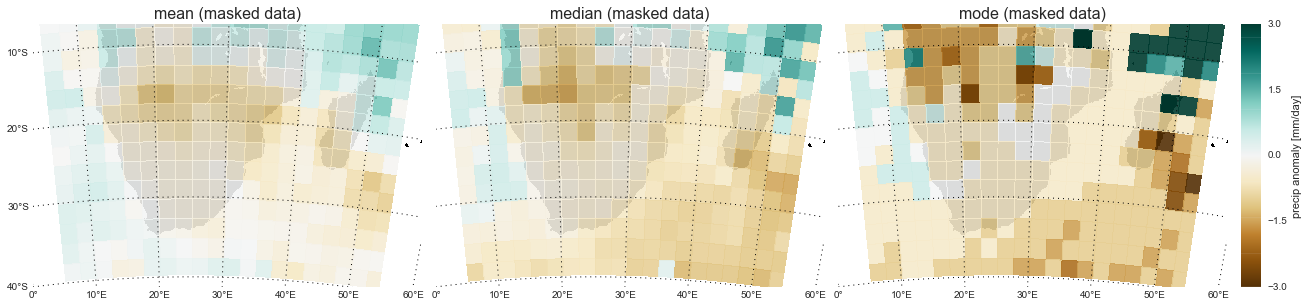

In [6]:
#--- Show some example time slices
# list composite labels
comp_types = comps.keys()
# initiate counter
c = 0 
# set image
fig = plt.figure(figsize=(22.,18.)) 
plt.figure() 
# divide into a grid, with common color bar
grid_top = ImageGrid(fig, 211, nrows_ncols = (1, 3),
                     cbar_location = "right",
                     cbar_mode="single",
                     cbar_pad=.2,
                     axes_pad=.2) 
# loop over grid elements
for g, node in zip(grid_top,comp_types):
    # go to current grid element
    plt.sca(g) 
    # set region/projection
    chart = Basemap(projection='lcc',resolution='c',
                    lat_0=-17,lon_0=25,
                    llcrnrlat=-40,urcrnrlat=-5.,
                    llcrnrlon=0,urcrnrlon=55) 
    # mark land mass
    chart.drawlsmask(land_color='black') 
    # draw parallels and meridian on border maps
    if (c == 0) :
        _ = chart.drawparallels(np.arange(-90.,91.,10.),labels=[True,False,False,False],dashes=[1,4])
        _ = chart.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[1,4])
    else :
        _ = chart.drawparallels(np.arange(-90.,91.,10.),labels=[False,False,False,False],dashes=[1,4])
        _ = chart.drawmeridians(np.arange(-180.,181.,10.),labels=[False,False,False,True],dashes=[1,4])
    # overlay precip anomaly
    sm = chart.pcolormesh(lons,lats,comps[node],shading='flat',latlon=True,
                          alpha=0.9,cmap='BrBG',vmin=-3,vmax=3)

    # label nodes
    #plt.title('['+str(c/4)+', '+str(c%4)+']')
    plt.title(comp_types[c],fontsize=16)
    
    # iterate counter
    c += 1
    
# add color bar 
cb = grid_top.cbar_axes[0].colorbar(sm)
cax = grid_top.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text('precip anomaly [mm/day]')

# save figure
plt.savefig('comp_examples_errmasking.png')
